In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [19]:
# from os import listdir
# from os.path import isfile, join

# folder_path = 'data'
# files = [f for f in listdir(folder_path) if isfile(join(folder_path, f)) and f.endswith('.csv')]
# df = pd.concat([pd.read_csv(join(folder_path, f), encoding='latin-1') for f in files], ignore_index=True)


In [21]:
df = pd.read_csv('data.csv')

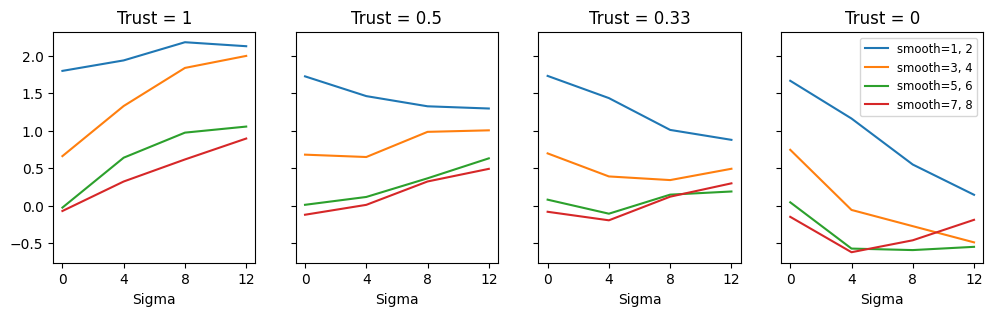

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
Trust = [1, 0.5, 0.33, 0]
Sigma = [0, 4, 8, 12]
for i in range(len(Trust)):
    d1 = df[df['trust']==Trust[i]]
    for j in range(4):
        d2 = d1[(d1['smoothness']==(j*2+2))|(d1['smoothness']==(j*2+2))]
        temp = []
        for sigma in Sigma:
            d3 = d2[d2['sigma']==sigma]
            temp.append(d3['diverse'].mean()-d3['expert'].mean())
        axs[i].plot(temp, label='smooth='+str(j*2+1)+', '+str(j*2+2))
        axs[i].set_xlabel('Sigma')
        axs[i].set_xticks(range(len(Sigma)))
        axs[i].set_xticklabels(Sigma)
        axs[i].set_title('Trust = '+str(Trust[i]))
plt.legend(fontsize='small')
# plt.savefig('../graphs/noise.png', dpi=450, bbox_inches='tight')

### Clean raw data

In [23]:
def strtolistc(val):
    """Convert string to list of floats"""
    ls = val.strip('[]').split(',')
    new = []
    for v in ls:
        new.append(float(v))
    return(np.array(new))

In [24]:
df['d_heuristics'] = df['d_heuristics'].apply(strtolistc)
df['x_heuristics'] = df['x_heuristics'].apply(strtolistc)
df['d_set'] = df['d_heuristics'].map(lambda x: set(x))
df['x_set'] = df['x_heuristics'].map(lambda x: set(x))
df['d_cover'] = df['d_set'].map(lambda x: len(x))
df['x_cover'] = df['x_set'].map(lambda x: len(x))

"""Diversity trumps ability"""
df['dta'] = df['diverse'] > df['expert'] # Frequency
df['dta'] = df['dta'].map(lambda x: int(x))

df['diff'] = df['diverse'] - df['expert'] # Diff mean score

In [25]:
# Add a constant term to the predictors for the intercept in the regression model
X = sm.add_constant(df[['trust']])
y = df['diff']

# Create and fit the OLS (Ordinary Least Squares) regression model
model = sm.OLS(y, X).fit()
model.summary()

In [28]:
model = smf.ols('diff ~ sigma + sigma:trust + trust', data=df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   diff   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     1378.
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:12:28   Log-Likelihood:                -19301.
No. Observations:               15702   AIC:                         3.861e+04
Df Residuals:                   15698   BIC:                         3.864e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5141      0.017     30.921      0.000       0.482       0.547
sigma          -0.0670      0.002    -27.728      0.000      -0.072      -0.062
sigma:trust     0.1456      0.004     35.056      0.000       0.137       0.154
trust           0.2195      0.029      7.676      0.000       0.163       0.276
==============================================================================
Omnibus:                      858.954   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1300.356
Skew:                           0.477   Prob(JB):                    4.28e-283
Kurtosis:                       4.039   Cond. No.                         37.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Check cover diversity

<Axes: >

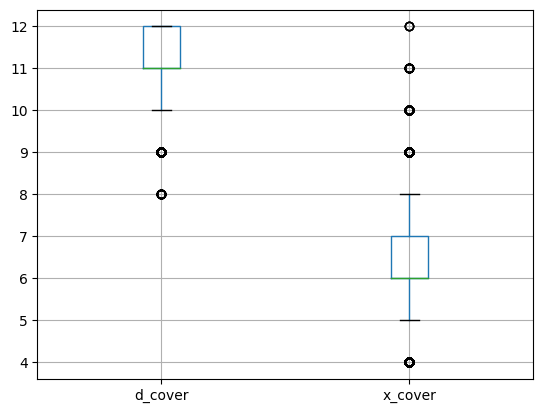

In [29]:
df.boxplot(column=['d_cover', 'x_cover'])

### Plot "diveristy trumps ability" frequency

In [30]:
sigma = 4
dta = df[(df['sigma']==sigma)][['dta', 'trust', 'smoothness']].groupby(['trust', 'smoothness'])['dta'].sum().to_frame().unstack()
dta = dta['dta']
count = df[(df['sigma']==sigma)][['dta', 'trust', 'smoothness']].groupby(['trust', 'smoothness'])['dta'].count().to_frame().unstack()
count = count['dta']
dta = dta/count

([<matplotlib.axis.XTick at 0x12d4ea8d0>,
 [Text(0, 0, 'none'),
  Text(1, 0, 'low'),
  Text(2, 0, 'moderate'),
  Text(3, 0, 'high')])

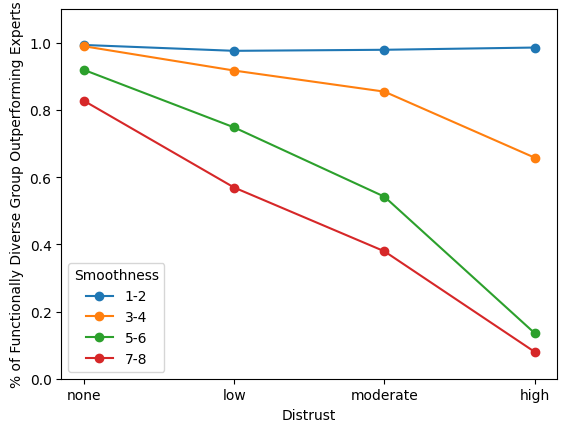

In [31]:
fig, ax = plt.subplots()
for i in range(1, 9, 2):
    data = list((dta[i]+dta[i+1])/2)
    data.reverse()
    ax.plot(data, label=str(i)+'-'+str(i+1), marker='o')
    ax.set_ylim(0, 1.1)
plt.xlabel('Distrust')
plt.ylabel('% of Functionally Diverse Group Outperforming Experts')
plt.legend(title='Smoothness')
plt.xticks((0, 1, 2, 3), ['none', 'low', 'moderate', 'high'])

# plt.savefig('../graphs/freq4.png', dpi=350, bbox_inches='tight')

### Plot difference in mean score

In [32]:
diff = df[(df['sigma']==sigma)][['diff', 'trust', 'smoothness']].groupby(['trust', 'smoothness'])['diff'].mean().to_frame().unstack()
diff = diff['diff']

([<matplotlib.axis.XTick at 0x12d376050>,
 [Text(0, 0, 'none'),
  Text(1, 0, 'low'),
  Text(2, 0, 'moderate'),
  Text(3, 0, 'high')])

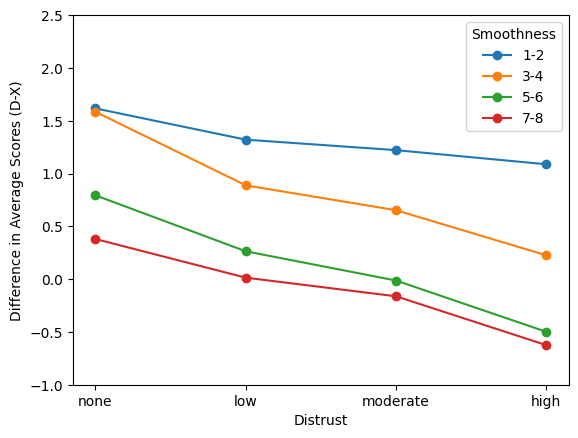

In [33]:
fig, ax = plt.subplots()
for i in range(1, 9, 2):
    data = list((diff[i]+diff[i+1])/2)
    data.reverse()
    ax.plot(data, label=str(i)+'-'+str(i+1), marker='o')
    ax.set_ylim(-1, 2.5)
plt.xlabel('Distrust')
plt.ylabel('Difference in Average Scores (D-X)')
plt.legend(title='Smoothness')
plt.xticks((0, 1, 2, 3), ['none', 'low', 'moderate', 'high'])

# plt.savefig('../graphs/diff4.png', dpi=350, bbox_inches='tight')